In [1]:
import ryn

from ryn.common import helper
helper.notebook()

%load_ext autoreload
%autoreload 2

changing directory

In [2]:
# https://htmlcolorcodes.com/color-chart/material-design-color-chart/

C = {
    'grey': [
        '#fafafa', '#f5f5f5', '#eeeeee', '#e0e0e0', '#bdbdbd', '#9e9e9e', '#757575', '#616161', '#424242', '#212121'
    ],
    'blue grey': [
        '#eceff1', '#cfd8dc', '#b0bec5', '#90a4ae', '#78909c', '#607d8b', '#546e7a', '#455a64', '#37474f', '#263238'
    ],
    'brown': [
        '#efebe9', '#d7ccc8', '#bcaaa4', '#a1887f', '#8d6e63', '#795548', '#6d4c41', '#5d4037', '#4e342e', '#3e2723'
    ],
    'pink': [
        '#fce4ec', '#f8bbd0', '#f48fb1', '#f06292', '#ec407a', '#e91e63', '#d81b60', '#c2185b', '#ad1457', '#880e4f', '#ff80ab', '#ff4081', '#f50057', '#c51162'
    ],
    'blue': [
        '#e3f2fd', '#bbdefb', '#90caf9', '#64b5f6', '#42a5f5', '#2196f3', '#1e88e5', '#1976d2', '#1565c0', '#0d47a1', '#82b1ff', '#448aff', '#2979ff', '#2962ff'
    ],
    'amber': [
        '#fff8e1', '#ffecb3', '#ffe082', '#ffd54f', '#ffca28', '#ffc107', '#ffb300', '#ffa000', '#ff8f00', '#ff6f00', '#ffe57f', '#ffd740', '#ffc400', '#ffab00'
    ],
}

In [ ]:
import PIL as pil
import PIL.ImageDraw

import numpy as np
import matplotlib.pyplot as plt

from itertools import zip_longest

def f():
    P = 10
    N = 150

    offset, size = N + P, N - P
    height, width = offset * len(C), offset * max(len(clr) for clr in C.values())

    img = pil.Image.new('RGB', (width, height), color='white')
    draw = pil.ImageDraw.Draw(img)

    for name, y in zip(C, range(P, height, offset)):
        if not name:
            continue

        for j, (x, val) in enumerate(zip_longest(range(P, width, offset), C[name])):
            if not x:
                continue

            draw.rectangle((x, y, (x + size), (y + size)), fill=val)

    plt.imshow(np.asarray(img))

f()

In [3]:
from ryn.text import util

def f():
    exps = util.Experiments('data/iea.irt.sheet.csv')
    data = {f'{exp.exp} [{exp.identifier}.{exp.sentences}.{exp.mode}]': exp for exp in exps}
    assert len(exps) == len(data)
    return data

data = f()
print(list(data)[0], f'+ {len(data)} more')

s01 [irt.fb.irt.30.masked]

+ 76 more

In [8]:
import yaml
from dataclasses import replace

def f(data):
    # load full evaluation data
    new, count = {}, 0
    for name, exp in ((name, exp) for name, exp in data.items() if exp.checkpoint):

        try:
            path = exp.path
        except ryn.RynError:
            continue

        yml_file = path / 'ryn' / ('evaluation.' + exp.checkpoint + '.yml')
        if not yml_file.exists():
            continue

        with yml_file.open(mode='r') as fd:
            metrics = yaml.load(fd, Loader=yaml.FullLoader)

        exp = replace(exp, metrics=metrics[exp.checkpoint])
        count += 1
        new[name] = exp

    print(f'loaded metrics for {count}/{len(data)} experiments')
    return new

data = f(data)

loaded metrics for 70/76 experiments

In [5]:
from ryn.common import plotter
path = helper.path(ryn.ENV.DATA_DIR / 'paper',  create=True)

# PLOTS

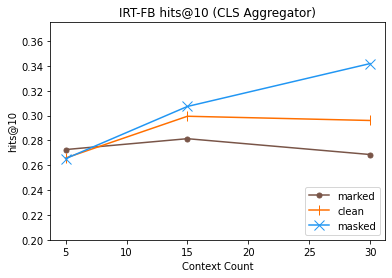

cannot find m02 [irt.cde.irt.5.clean]

cannot find m02 [irt.cde.irt.15.masked]

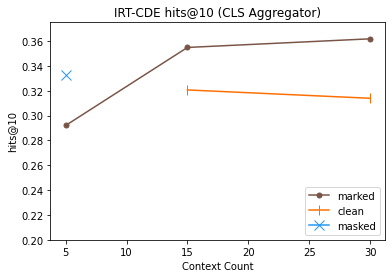

In [21]:
def f(
        data,
        identifier: str = None,   # e.g. irt.fb.irt
        title: str = None,
):
    assert identifier
    assert title

    colors = [C['brown'][5], C['amber'][9], C['blue'][5], C['grey'][5]]
    marker = ['.', '|', 'x', '+']

    steps = (5, 15, 30)

    plt = plotter.Plotter(
        title=title,
        xlabel='Context Count',
        ylabel='hits@10',
        fname=str(path / f'plot-ctxlen-{identifier.replace(".", "-")}')
    )

    # baseline

    # plt.ax.plot(
    #     steps,
    #     [0.1468, 0.1689, 0.1708],
    #     color=colors[-1],
    #     marker=marker[-1],
    #     markersize=10,
    #     label='baseline')

    # loaded values

    def gen():
        for i, mode in enumerate(('marked', 'clean', 'masked')):
            for exp in ('m02', ):
                yield i, mode, exp

    for i, mode, exp in gen():
        x, y = steps, []
        for sents in steps:
            key = f'{exp} [{identifier}.{sents}.{mode}]'
            if key not in data or not data[key].metrics:
                print(f'cannot find {key}')
                y.append(None)
                continue

            y.append(data[key].metrics['test']['hits_at_k']['both']['avg'][10])

        plt.ax.plot(
            x, y,
            color=colors[i],
            marker=marker[i],
            markersize=10,
            label=mode)

    plt.ax.set_ylim(ymin=0.2, ymax=0.375)
    plt.ax.legend(loc='lower right')
    plt.plot()

f(data, identifier='irt.fb.irt', title="IRT-FB hits@10 (CLS Aggregator)")
f(data, identifier='irt.cde.irt', title='IRT-CDE hits@10 (CLS Aggregator)')
# list(data.keys())

# TABLES

In [13]:
import numpy as np
from datetime import datetime
from tabulate import tabulate

## Big Overview

Comparing different text modes and mapper configurations.

In [19]:
def f():

    def gen():
        for mode in ('marked', 'clean', 'masked'):
            for exp in ('s03', 's02', 's01', 'm02'):
                yield mode, exp

    rows, blocks = [], []

    for mode, expname in gen():
        row = [
            mode,
            'single' if expname.startswith('s') else 'multi',
            {'s01': 'cls', 's02': 'max', 's03': 'max\\textdagger', 'm02': 'cls'}[expname],
        ]

        for split in ('fb', 'cde'):
            exp = data.get(f'{expname} [irt.{split}.irt.30.{mode}]', None)
            if not exp:
                row += [0 for _ in range(4)]
            else:
                metrics = exp.metrics['test']
                row += [
                    metrics['hits_at_k']['both']['avg'][1],
                    metrics['hits_at_k']['both']['avg'][5],
                    metrics['hits_at_k']['both']['avg'][10],
                    metrics['mean_reciprocal_rank']['both']['avg'],
                ]

        rows.append(row)

    skip = 3
    maxvals = np.argmax(np.array([
        row[skip:] for row in rows
    ]), axis=0)
    maxvals = [None for _ in range(skip)] + list(maxvals)

    def fmt(val, row_idx, col_idx):
        if not type(val) is float:
            return val

        val = f'{val * 100:5.2f}'
        if maxvals[col_idx] == row_idx:
            return f'\\textbf{{{val}}}'

        return val

    rows = [[fmt(cell, i, j) for j, cell in enumerate(row)] for i, row in enumerate(rows)]

    print(f'%% generated {datetime.now()}')
    print(tabulate(rows, tablefmt='latex_raw'))

f()

%% generated 2021-01-16 11:19:34.965183

\begin{tabular}{lllllllllll}
\hline
 marked & single & max\textdagger & 9.44           & 16.38          & 19.75          & 13.08          & 12.35          & 21.57          & 26.22          & 16.90          \\
 marked & single & max            & 8.68           & 15.60          & 19.47          & 12.45          & 0              & 0              & 0              & 0              \\
 marked & single & cls            & 10.39          & 18.14          & 22.75          & 14.68          & 15.44          & 26.99          & 32.15          & 21.11          \\
 marked & multi  & cls            & 11.20          & 21.19          & 26.86          & 16.55          & 17.74          & 30.43          & 36.18          & 24.07          \\
 clean  & single & max\textdagger & 9.64           & 16.57          & 20.29          & 13.31          & 11.90          & 21.60          & 25.88          & 16.65          \\
 clean  & single & max            & 11.39          & 20.74          & 25.34          & 16.14       

## Single-Sentence Comparison

Using a single sentence per entity with IRT (random),
OWE (wikidata description), and CDE (first Wikipedia page sentence)